In [1]:
# read in data
article = []
# titles
titles = []

import os
for root, dirs, files in os.walk("../mao/"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                sentences = input.read()
            article.append(sentences)
            titles.append(file)
            
print(len(article))
print(len(titles))

../mao/REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
../mao/ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
../mao/BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
../mao/WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
../mao/A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
../mao/ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
6
6


In [2]:
# concatenate text
text = ''.join(article)

len(text)

174475

In [3]:
# remove reference mark, e.g. '[1]'

import re

text = re.sub(r'\[\d{1,3}\]' ,'', text)
len(text)

174164

In [4]:
# using nltk, split text into sentences

from nltk.tokenize import sent_tokenize

sentences = sent_tokenize(text)

len(sentences)

1250

## Get bert embedding

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('stsb-roberta-large')

sentence_embeddings = model.encode(sentences)

sentence_embeddings

array([[ 1.0514753 , -0.15698974, -0.6388856 , ...,  1.3926277 ,
        -2.19222   ,  0.46881217],
       [ 1.1240852 ,  0.14005217, -0.02561224, ...,  1.121161  ,
        -1.7365693 ,  1.1247581 ],
       [ 0.7501117 ,  0.2162219 ,  0.7917    , ...,  0.90062666,
        -1.2981623 ,  0.9176288 ],
       ...,
       [-0.35767937,  1.0318004 ,  0.84859633, ..., -0.23851372,
        -1.2277536 ,  0.92608917],
       [-1.0354404 ,  1.2909242 ,  0.2999326 , ...,  0.4461265 ,
        -1.5273455 ,  0.55726624],
       [-0.13420409,  0.4985413 ,  0.4791156 , ..., -1.0412669 ,
        -0.98391706,  0.46094227]], dtype=float32)

## Get the vector norm

In [6]:
import numpy as np
np.linalg.norm(sentence_embeddings[0])

27.67779

In [7]:
sentence_norm = [np.linalg.norm(x) for x in sentence_embeddings]
len(sentence_norm)

1250

In [8]:
len(sentence_embeddings)

1250

In [9]:
sentence_norm[0:10]

[27.67779,
 27.741547,
 27.652258,
 30.115093,
 27.625107,
 25.836132,
 28.174456,
 27.090067,
 28.030947,
 28.115288]

## Clustering by KMeans

In [10]:
# normalize data first
from sklearn.preprocessing import normalize
# normalize the data help k-means get better performance
norm_data = normalize(sentence_embeddings, norm='l2')

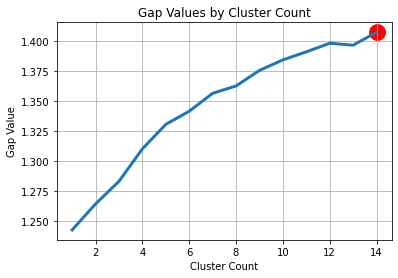

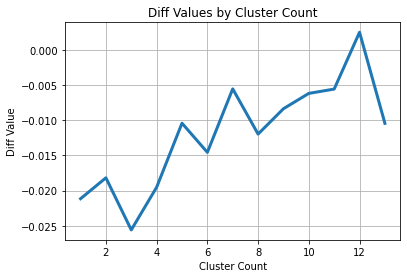

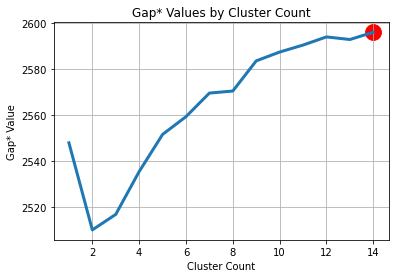

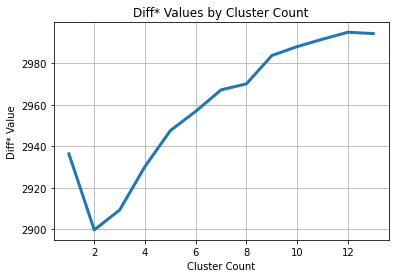

In [11]:
from gap_statistic import OptimalK
import numpy as np
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')

# limit to 1~15 cluster
n_clusters = optimalK(norm_data, cluster_array=np.arange(1, 15))
optimalK.plot_results()

In [12]:
# using the best K = 13 for k-means
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=13, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(norm_data)

y_km

array([11, 11,  6, ...,  2,  2, 10], dtype=int32)

In [13]:
## create a array that assign each sentence to its group
groups = []

for i in range (0, 13):
    groups.append([])

for idx, embed in enumerate(norm_data):
    groups[y_km[idx] - 1].append(idx)

In [14]:
def get_sum_distances(group):
    """input a group indicis of sentences, get a list of sum of cosine distance between
    current sentence and other sentences in the text(score)
    @param: a group of index, index of sentence
    @return score(float)
    """
    # construct data for group info
    data = np.array([norm_data[i] for i in group])
    # to store the result
    res = []
    
    for idx, _ in enumerate(data):
        # data has been normalized, cosine distanct can be calculated as np.dot()
        scores = np.dot(data, data[idx].T)
        res.append(np.sum(scores))
    return res

In [15]:
## pick up top score for each group

for idx, group in enumerate(groups):
    score_list = get_sum_distances(group)
    max_idx = np.argmax(score_list)
    print('Group:' + str(idx + 1) + ': \n')
    print('Sentence idx:{}'.format(group[max_idx]))
    print(sentences[group[max_idx]])
    print('\n')

Group:1: 

Sentence idx:136
Those who used to rank lowest now rank above everybody else; and so this is called "turning things upside down".


Group:2: 

Sentence idx:894
We are the leaders and organizers of the revolutionary war as well as the leaders and organizers of the life of the masses.


Group:3: 

Sentence idx:1202
The semi-owner peasants are worse off than the owner-peasants because every year they are short of about half the food they need, and have to make up this deficit by renting land from others, selling part of their labour power, or engaging in petty trading.


Group:4: 

Sentence idx:58
"IT'S TERRIBLE!"


Group:5: 

Sentence idx:1219
If by chance you get into intimate conversation with them, they invariably pour out their endless grievances.


Group:6: 

Sentence idx:966
This is the reason why many Red regimes emerging at favourable moments before last April in places like Canton, Haifeng and LuFeng, the Hunan-Kiangsi border area, southern Hunan, Liling and Huangan w

In [16]:
# get each group max norm sentence id
for g_id, g in enumerate(groups):
    # get all idx in this group
    idx_list = [idx for idx in g]
    # get all norm value
    norm_value = [sentence_norm[i] for i in idx_list]
    # get max one
    max_idx = np.argmax(norm_value)
    global_max_idx = idx_list[max_idx]
    print('Group:' + str(g_id + 1) + ': \n')
    print('Max Norm value Sentences global id:{}'.format(global_max_idx))
    

Group:1: 

Max Norm value Sentences global id:843
Group:2: 

Max Norm value Sentences global id:894
Group:3: 

Max Norm value Sentences global id:210
Group:4: 

Max Norm value Sentences global id:858
Group:5: 

Max Norm value Sentences global id:65
Group:6: 

Max Norm value Sentences global id:412
Group:7: 

Max Norm value Sentences global id:264
Group:8: 

Max Norm value Sentences global id:653
Group:9: 

Max Norm value Sentences global id:500
Group:10: 

Max Norm value Sentences global id:784
Group:11: 

Max Norm value Sentences global id:150
Group:12: 

Max Norm value Sentences global id:1088
Group:13: 

Max Norm value Sentences global id:36


In [18]:
# compare
for idx, group in enumerate(groups):
    score_list = get_sum_distances(group)
    max_idx = np.argmax(score_list)
    print('Group:' + str(idx + 1) + ': \n')
    print('Top Sentence idx:{}'.format(group[max_idx]))
    # get all idx in this group
    idx_list = [idx for idx in group]
    # get all norm value
    norm_value = [sentence_norm[i] for i in idx_list]
    # get max one
    max_idx = np.argmax(norm_value)
    global_max_idx = idx_list[max_idx]
    print('Max Norm value Sentences global id:{}'.format(global_max_idx))
    print('Max Norm Sentence:\n')
    print(sentences[global_max_idx])
    print('\n')

Group:1: 

Top Sentence idx:136
Max Norm value Sentences global id:843
Max Norm Sentence:

Much has also been done in other fields.


Group:2: 

Top Sentence idx:894
Max Norm value Sentences global id:894
Max Norm Sentence:

We are the leaders and organizers of the revolutionary war as well as the leaders and organizers of the life of the masses.


Group:3: 

Top Sentence idx:1202
Max Norm value Sentences global id:210
Max Norm Sentence:

Without the poor peasants there would be no revolution.


Group:4: 

Top Sentence idx:58
Max Norm value Sentences global id:858
Max Norm Sentence:

The wooden bridge over there is too narrow and people may fall off.


Group:5: 

Top Sentence idx:1219
Max Norm value Sentences global id:65
Max Norm Sentence:

school then flooding the city, even quite revolutionary-minded people became down-hearted as they pictured the events in the countryside in their mind's eye; and they were unable to deny the word "terrible".


Group:6: 

Top Sentence idx:966
Max No